In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import geopandas as gpd
from glob import glob
import matplotlib.pyplot as plt 
import seaborn as sns
import altair as alt
import plotly.express as px
import numpy as np

In [3]:
la_data = pd.read_csv('/Users/florence/Desktop/citizen_science/la_data_with_greenspace_flag.csv', index_col=0)
la_data.head()

,observed_on_string,time_observed_at,created_time_zone,created_at,updated_at,description,user_id,user_login,quality_grade,reviewed_by,...,taxon_parent_id,taxon_native,taxon_endemic,taxon_threatened,taxon_search_rank,taxon_observations,identifications,challenge,geometry,greenspace_flag
id,,,,,,,,,,,,,,,,,,,,,
5591391,Fri Apr 14 2017 09:34:12 GMT-0700 (PDT),2017-04-14T09:34:12-07:00,America/Los_Angeles,2017-04-06T09:34:29-07:00,2018-01-13T14:28:01-08:00,NaN,436798,laurachun,research,"[1850, 73705, 436798]",...,52855,True,False,False,11983,11983,"[{'user_id': 73705, 'category': 'supporting', ...",../../data/CNC_Los_Angeles_2017,POINT (-118.2013750636 34.0975227999),1
5591694,Sat Apr 15 2017 10:18:50 GMT-0700 (PDT),2017-04-15T10:18:50-07:00,America/Los_Angeles,2017-04-06T10:19:03-07:00,2018-01-13T14:28:03-08:00,NaN,436798,laurachun,research,"[1850, 6971, 73705, 436798]",...,53145,True,False,False,6476,6476,"[{'user_id': 73705, 'category': 'supporting', ...",../../data/CNC_Los_Angeles_2017,POINT (-118.201411022 34.0993599873),1
5684540,Fri Apr 14 2017 00:03:16 GMT-0700 (PDT),2017-04-14T00:03:16-07:00,America/Los_Angeles,2017-04-14T00:04:16-07:00,2018-01-13T14:31:44-08:00,NaN,6743,lhiggins,needs_id,"[1850, 6743, 52839, 275891]",...,52380,False,False,False,55396,55396,"[{'user_id': 275891, 'category': 'supporting',...",../../data/CNC_Los_Angeles_2017,POINT (-118.3108783227 34.0710921725),0
5684550,Fri Apr 14 2017 00:04:42 GMT-0700 (PDT),2017-04-14T00:04:42-07:00,America/Los_Angeles,2017-04-14T00:05:31-07:00,2018-01-13T14:31:44-08:00,NaN,6743,lhiggins,needs_id,"[1850, 6743, 10285, 12809, 73705, 81261, 440756]",...,933174,False,False,False,8938,8938,"[{'user_id': 81261, 'category': 'improving', '...",../../data/CNC_Los_Angeles_2017,POINT (-118.3107719072 34.0711111849),0
5684551,Fri Apr 14 2017 00:04:06 GMT-0700 (PDT),2017-04-14T00:04:06-07:00,America/Los_Angeles,2017-04-14T00:05:32-07:00,2017-04-14T05:30:19-07:00,NaN,15419,mordenana,needs_id,"[1850, 15419]",...,47119,False,False,False,1420015,1420015,"[{'user_id': 15419, 'category': None, 'disagre...",../../data/CNC_Los_Angeles_2017,POINT (-117.9964166401 34.1440870897),0


In [4]:
la_data.greenspace_flag.value_counts()

0    69556
1    22137
Name: greenspace_flag, dtype: int64

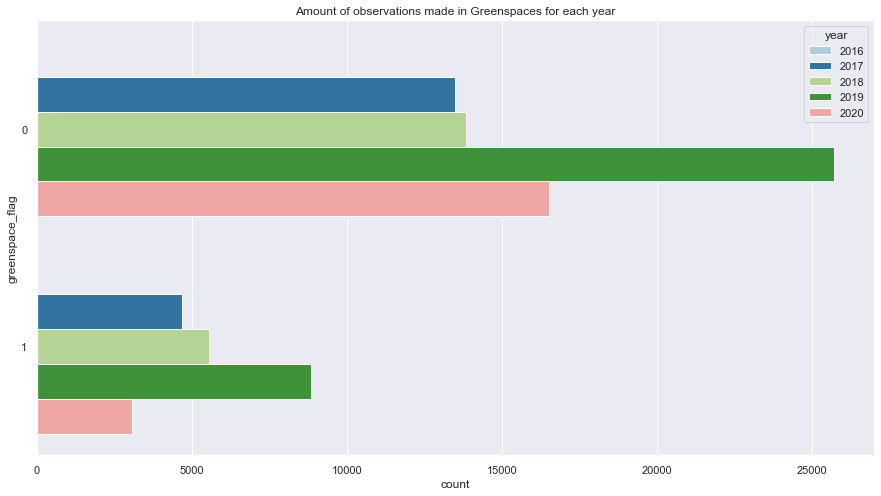

In [5]:
la_data['time_observed_at'] = pd.to_datetime(la_data['time_observed_at'], utc=True)
la_data['year'] = pd.DatetimeIndex(la_data['time_observed_at']).year
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,8))
plt.title('Amount of observations made in Greenspaces for each year')
ax = sns.countplot(y="greenspace_flag", hue="year", data=la_data, palette='Paired')

In [7]:
fig = ax.get_figure()
fig.savefig("la_greenspace_overview_absolute.png")

[Text(0.5, 0, 'amount of observations'), Text(0, 0.5, 'greenspace flag')]

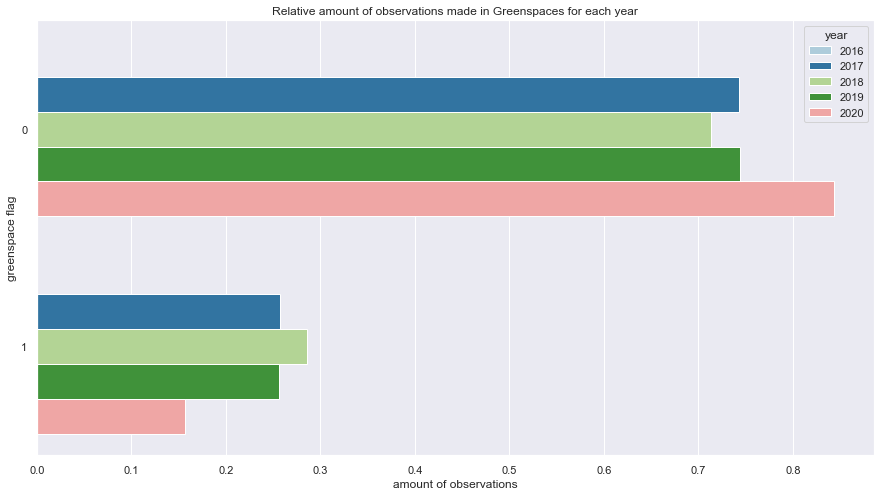

In [8]:
grouped_df = la_data.groupby(['year', 'greenspace_flag']).count()['observed_on_string'].to_frame()
grouped_df.reset_index(inplace=True)
grouped_df.set_index(['year', 'greenspace_flag'], inplace=True)
grouped_df['proportions'] = 0.
for y in grouped_df.index.unique(level='year').tolist()[1:]:
    grouped_df.at[(y, 0), 'proportions'] = grouped_df.loc[(y, 0), 'observed_on_string'] / (grouped_df.loc[(y, 0), 'observed_on_string'] + grouped_df.loc[(y, 1), 'observed_on_string'])
    grouped_df.at[(y, 1), 'proportions'] = grouped_df.loc[(y, 1), 'observed_on_string'] / (grouped_df.loc[(y, 0), 'observed_on_string'] + grouped_df.loc[(y, 1), 'observed_on_string'])
grouped_df.reset_index(inplace=True)
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,8))
plt.title('Relative amount of observations made in Greenspaces for each year')
ax = sns.barplot(x="proportions", y="greenspace_flag", hue="year", data=grouped_df, palette='Paired', orient='h')
ax.set(xlabel='amount of observations', ylabel='greenspace flag')

In [9]:
fig = ax.get_figure()
fig.savefig("la_greenspace_overview_relative.png")

In [10]:
la_2018 = la_data[la_data.year == 2018]
# select the top-20 users: 
ranks = la_2018.groupby('user_login').count()['year'].to_frame()
ranks.rename(columns={'year':'num_obsverations'}, inplace=True)
ranks.head()

,num_obsverations
user_login,
_miguel_,3
aaliyah794,8
aartvark,1
abard,5
abdhsc23,2


In [11]:
ranks.reset_index(inplace=True)
ranks.sort_values(by='num_obsverations', inplace=True, ascending=False)
ranks.head()

,user_login,num_obsverations
148,cedric_lee,1414
689,quantron,960
216,dlbowls,767
630,neontetraploid,616
623,natureinla,599


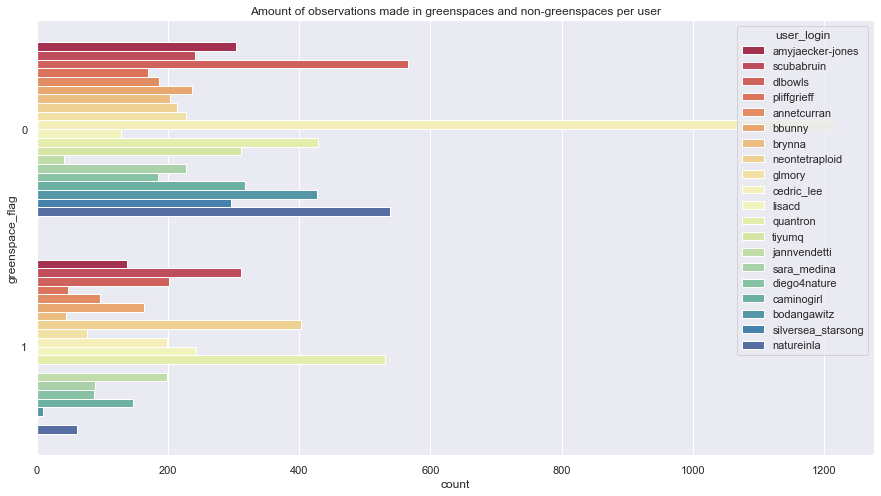

In [12]:
top_20 = ranks.head(20)
top_20_users = top_20.user_login.values.tolist()
la_top_20 = la_2018[la_2018['user_login'].isin(top_20_users)]
plt.figure(figsize=(15,8))
plt.title('Amount of observations made in greenspaces and non-greenspaces per user')
ax = sns.countplot(y="greenspace_flag", hue="user_login", data=la_top_20, palette='Spectral')

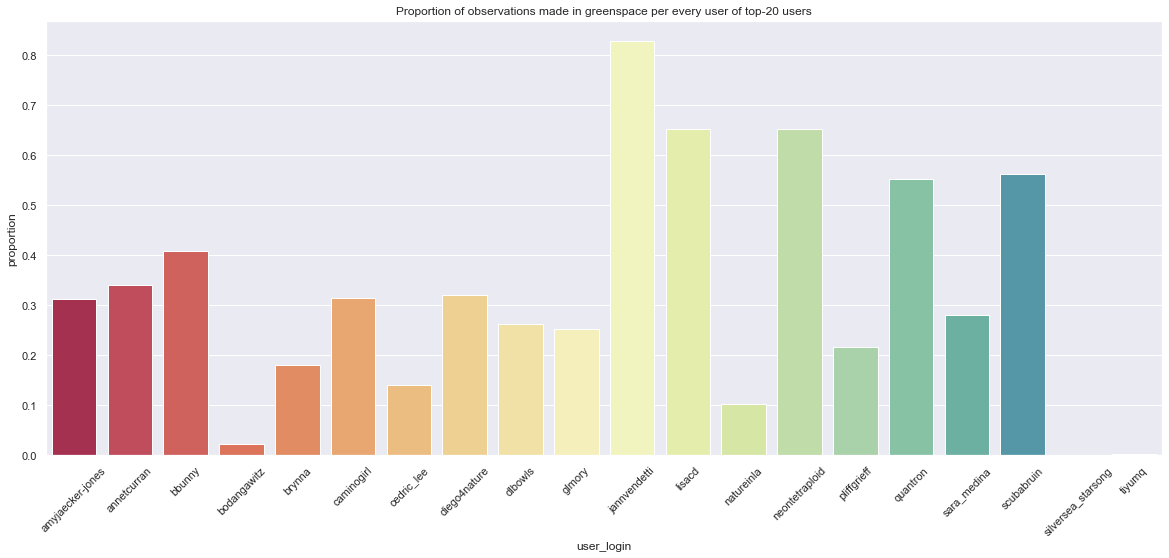

In [13]:
proportion_df = la_top_20.groupby(['user_login', 'greenspace_flag']).size().to_frame()
proportion_df.reset_index(inplace=True)
proportion_df.rename(columns={0: 'num_observations'}, inplace=True)
proportion_df['proportion'] = 0
proportion_df.set_index(['user_login', 'greenspace_flag'], inplace=True)
for user in proportion_df.index.unique(level='user_login'):
    if (user, 1) in proportion_df.index.unique() and (user, 0) in proportion_df.index.unique():
        proportion_df.loc[user, 'proportion'] = proportion_df.loc[(user, 1), 'num_observations'] / (proportion_df.loc[(user, 1), 'num_observations'] + proportion_df.loc[(user, 0), 'num_observations'])
    elif (user, 0) not in proportion_df.index.unique(): 
        proportion_df.loc[user, 'proportion'] = 1.0
        
proportion_df['num_obs'] = 0
for user in proportion_df.index.unique(level='user_login'):
    if (user, 1) in proportion_df.index.unique() and (user, 0) in proportion_df.index.unique():
        proportion_df.loc[user, 'num_obs'] = proportion_df.loc[(user, 1), 'num_observations'] + proportion_df.loc[(user, 0), 'num_observations']
    elif (user, 0) not in proportion_df.index.unique() and (user, 1) in proportion_df.index.unique(): 
        proportion_df.loc[user, 'num_obs'] = proportion_df.loc[(user, 1), 'num_observations']
    elif (user, 0) in proportion_df.index.unique() and (user, 1) not in proportion_df.index.unique(): 
        proportion_df.loc[user, 'num_obs'] = proportion_df.loc[(user, 0), 'num_observations']

proportion_df.reset_index(inplace=True)
new_df = proportion_df.drop(columns=['greenspace_flag', 'num_observations'])
new_df.drop_duplicates(inplace=True)
plt.figure(figsize=(20,8))
plt.title('Proportion of observations made in greenspace per every user of top-20 users')
plt.xticks(rotation=45)
ax = sns.barplot(x="user_login", y="proportion", data=new_df, palette='Spectral')

### 2016:

In [14]:
la_16 = la_data[la_data.year == 2016]
all_proportions_16 = la_16.groupby(['user_login', 'greenspace_flag']).size().to_frame()
all_proportions_16.reset_index(inplace=True)
all_proportions_16.rename(columns={0: 'num_observations'}, inplace=True)
all_proportions_16['proportion'] = 0
all_proportions_16.set_index(['user_login', 'greenspace_flag'], inplace=True)

for user in all_proportions_16.index.unique(level='user_login'):
    if (user, 1) in all_proportions_16.index.unique() and (user, 0) in all_proportions_16.index.unique():
        all_proportions_17.loc[user, 'proportion'] = all_proportions_16.loc[(user, 1), 'num_observations'] / (all_proportions_16.loc[(user, 1), 'num_observations'] + all_proportions_16.loc[(user, 0), 'num_observations'])
    elif (user, 0) not in all_proportions_16.index.unique(): 
        all_proportions_16.loc[user, 'proportion'] = 1.0
        
all_proportions_16.head()

,,num_observations,proportion
user_login,greenspace_flag,,
elysiumrezident,0,1,0
wildguyry,0,1,0


In [15]:
all_proportions_16.reset_index(inplace=True)
all_proportions_16 = all_proportions_16.drop(columns=['greenspace_flag', 'num_observations'])
all_proportions_16.drop_duplicates(inplace=True)
all_proportions_16.head()

,user_login,proportion
0,elysiumrezident,0
1,wildguyry,0


### 2017:

In [16]:
la_17 = la_data[la_data.year == 2017]
all_proportions_17 = la_17.groupby(['user_login', 'greenspace_flag']).size().to_frame()
all_proportions_17.reset_index(inplace=True)
all_proportions_17.rename(columns={0: 'num_observations'}, inplace=True)
all_proportions_17['proportion'] = 0
all_proportions_17.set_index(['user_login', 'greenspace_flag'], inplace=True)

for user in all_proportions_17.index.unique(level='user_login'):
    if (user, 1) in all_proportions_17.index.unique() and (user, 0) in all_proportions_17.index.unique():
        all_proportions_17.loc[user, 'proportion'] = all_proportions_17.loc[(user, 1), 'num_observations'] / (all_proportions_17.loc[(user, 1), 'num_observations'] + all_proportions_17.loc[(user, 0), 'num_observations'])
    elif (user, 0) not in all_proportions_17.index.unique(): 
        all_proportions_17.loc[user, 'proportion'] = 1.0
        
all_proportions_17.head()

,,num_observations,proportion
user_login,greenspace_flag,,
aakritidua,0,6,0.0
aamacalino15,0,6,0.0
abard,0,1,0.0
abby-pina,0,1,0.0
abdela14,0,10,0.0


In [17]:
all_proportions_17.reset_index(inplace=True)
new_proportions_17 = all_proportions_17.drop(columns=['greenspace_flag', 'num_observations'])
new_proportions_17.drop_duplicates(inplace=True)
new_proportions_17.head()

,user_login,proportion
0,aakritidua,0.0
1,aamacalino15,0.0
2,abard,0.0
3,abby-pina,0.0
4,abdela14,0.0


### 2018:

In [18]:
all_proportions_18 = la_2018.groupby(['user_login', 'greenspace_flag']).size().to_frame()
all_proportions_18.reset_index(inplace=True)
all_proportions_18.rename(columns={0: 'num_observations'}, inplace=True)
all_proportions_18['proportion'] = 0
all_proportions_18.set_index(['user_login', 'greenspace_flag'], inplace=True)

for user in all_proportions_18.index.unique(level='user_login'):
    if (user, 1) in all_proportions_18.index.unique() and (user, 0) in all_proportions_18.index.unique():
        all_proportions_18.loc[user, 'proportion'] = all_proportions_18.loc[(user, 1), 'num_observations'] / (all_proportions_18.loc[(user, 1), 'num_observations'] + all_proportions_18.loc[(user, 0), 'num_observations'])
    elif (user, 0) not in all_proportions_18.index.unique(): 
        all_proportions_18.loc[user, 'proportion'] = 1.0
        
all_proportions_18.head()

num_observations  proportion
user_login greenspace_flag                              
_miguel_   0                               3       0.000
aaliyah794 0                               1       0.875
           1                               7       0.875
aartvark   0                               1       0.000
abard      0                               5       0.000

In [19]:
all_proportions_18.reset_index(inplace=True)
new_proportions_18 = all_proportions_18.drop(columns=['greenspace_flag', 'num_observations'])
new_proportions_18.drop_duplicates(inplace=True)
new_proportions_18.head()

,user_login,proportion
0,_miguel_,0.000
1,aaliyah794,0.875
3,aartvark,0.000
4,abard,0.000
5,abdhsc23,0.000


In [20]:
new_proportions_18.sort_values(by='proportion', inplace=True, ascending=False)
new_proportions_18.head()

,user_login,proportion
572,keniae,1.0
973,skarlettfever,1.0
993,stanley7,1.0
992,stanharris,1.0
987,solera4,1.0


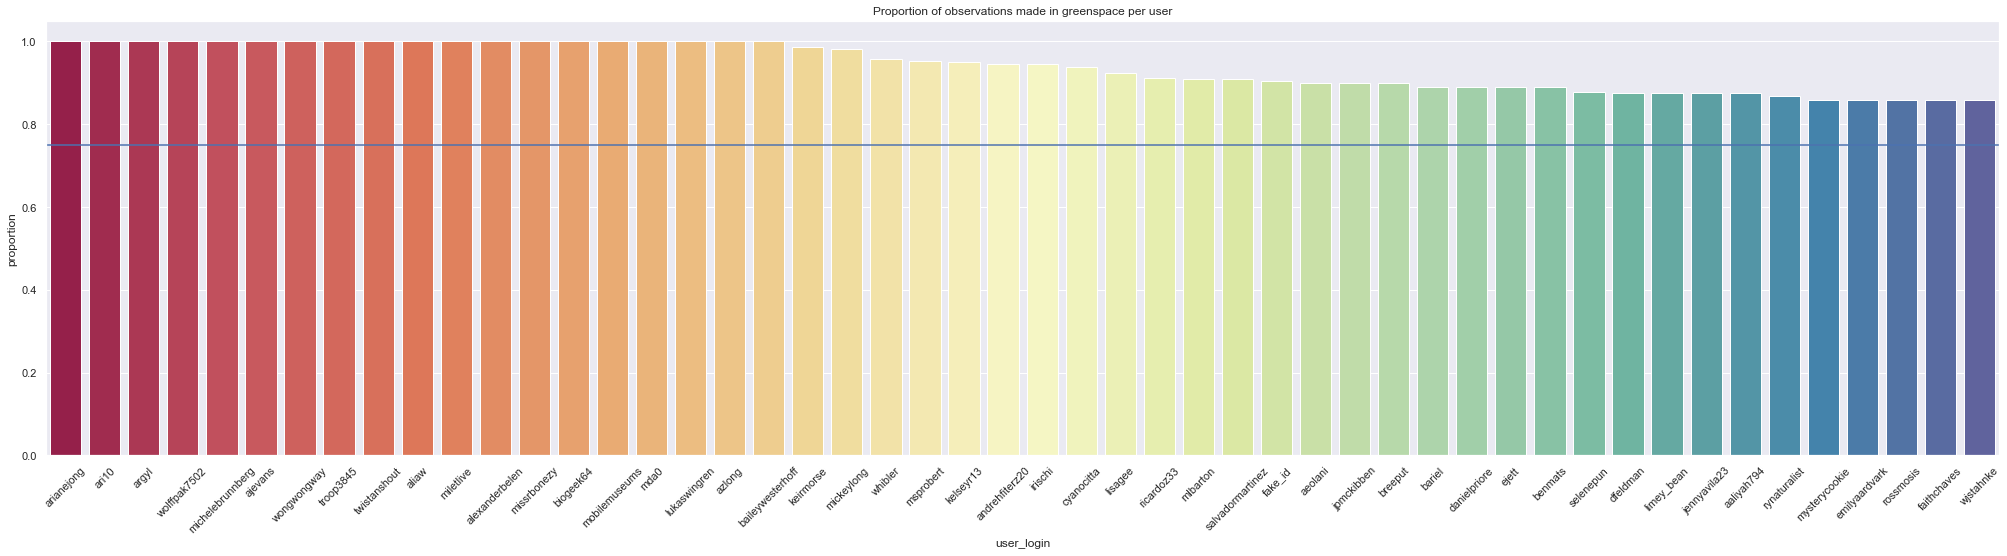

In [21]:
plt.figure(figsize=(35, 8))
plt.title('Proportion of observations made in greenspace per user')
plt.xticks(rotation=45)
ax = sns.barplot(x="user_login", y="proportion", data=new_proportions_18.iloc[100:150], palette='Spectral')
ax.axhline(0.75)

### 2019:

In [22]:
la_19 = la_data[la_data.year == 2019]
all_proportions_19 = la_19.groupby(['user_login', 'greenspace_flag']).size().to_frame()
all_proportions_19.reset_index(inplace=True)
all_proportions_19.rename(columns={0: 'num_observations'}, inplace=True)
all_proportions_19['proportion'] = 0
all_proportions_19.set_index(['user_login', 'greenspace_flag'], inplace=True)

for user in all_proportions_19.index.unique(level='user_login'):
    if (user, 1) in all_proportions_19.index.unique() and (user, 0) in all_proportions_19.index.unique():
        all_proportions_19.loc[user, 'proportion'] = all_proportions_19.loc[(user, 1), 'num_observations'] / (all_proportions_19.loc[(user, 1), 'num_observations'] + all_proportions_19.loc[(user, 0), 'num_observations'])
    elif (user, 0) not in all_proportions_19.index.unique(): 
        all_proportions_19.loc[user, 'proportion'] = 1.0
        
all_proportions_19.head()

,,num_observations,proportion
user_login,greenspace_flag,,
a_wandering_ecologist,1,25,1.0
aaliyahmack,0,3,0.0
aandb,0,2,0.0
abaca1,1,3,1.0
abakhdanyan,0,1,0.0


In [23]:
all_proportions_19.reset_index(inplace=True)
new_proportions_19 = all_proportions_19.drop(columns=['greenspace_flag', 'num_observations'])
new_proportions_19.drop_duplicates(inplace=True)
new_proportions_19.head()

,user_login,proportion
0,a_wandering_ecologist,1.0
1,aaliyahmack,0.0
2,aandb,0.0
3,abaca1,1.0
4,abakhdanyan,0.0


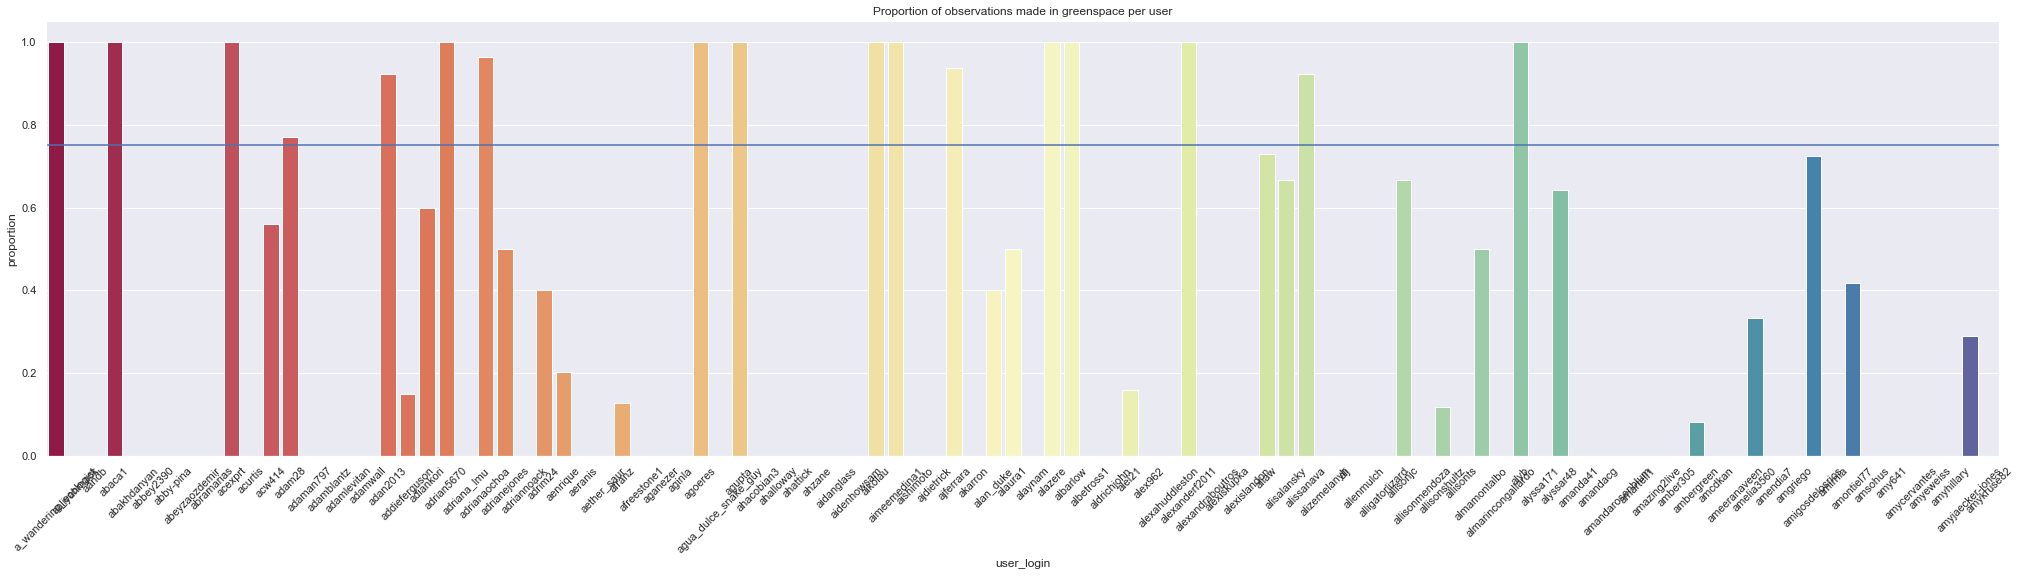

In [24]:
plt.figure(figsize=(35, 8))
plt.title('Proportion of observations made in greenspace per user')
plt.xticks(rotation=45)
ax = sns.barplot(x="user_login", y="proportion", data=new_proportions_19.head(100), palette='Spectral')
ax.axhline(0.75)

In [25]:
sf_20 = la_data[la_data.year == 2020]
all_proportions_20 = sf_20.groupby(['user_login', 'greenspace_flag']).size().to_frame()
all_proportions_20.reset_index(inplace=True)
all_proportions_20.rename(columns={0: 'num_observations'}, inplace=True)
all_proportions_20['proportion'] = 0
all_proportions_20.set_index(['user_login', 'greenspace_flag'], inplace=True)

for user in all_proportions_20.index.unique(level='user_login'):
    if (user, 1) in all_proportions_20.index.unique() and (user, 0) in all_proportions_20.index.unique():
        all_proportions_20.loc[user, 'proportion'] = all_proportions_20.loc[(user, 1), 'num_observations'] / (all_proportions_20.loc[(user, 1), 'num_observations'] + all_proportions_20.loc[(user, 0), 'num_observations'])
    elif (user, 0) not in all_proportions_20.index.unique(): 
        all_proportions_20.loc[user, 'proportion'] = 1.0
        
all_proportions_20.head()

,,num_observations,proportion
user_login,greenspace_flag,,
a_nigripinnis,0,1,0.0
aadougherty,1,2,1.0
aanar,0,4,0.0
aandb,0,3,0.0
aaronlopez,0,1,0.0


In [26]:
all_proportions_20.reset_index(inplace=True)
new_proportions_20 = all_proportions_20.drop(columns=['greenspace_flag', 'num_observations'])
new_proportions_20.drop_duplicates(inplace=True)
new_proportions_20.head()

,user_login,proportion
0,a_nigripinnis,0.0
1,aadougherty,1.0
2,aanar,0.0
3,aandb,0.0
4,aaronlopez,0.0


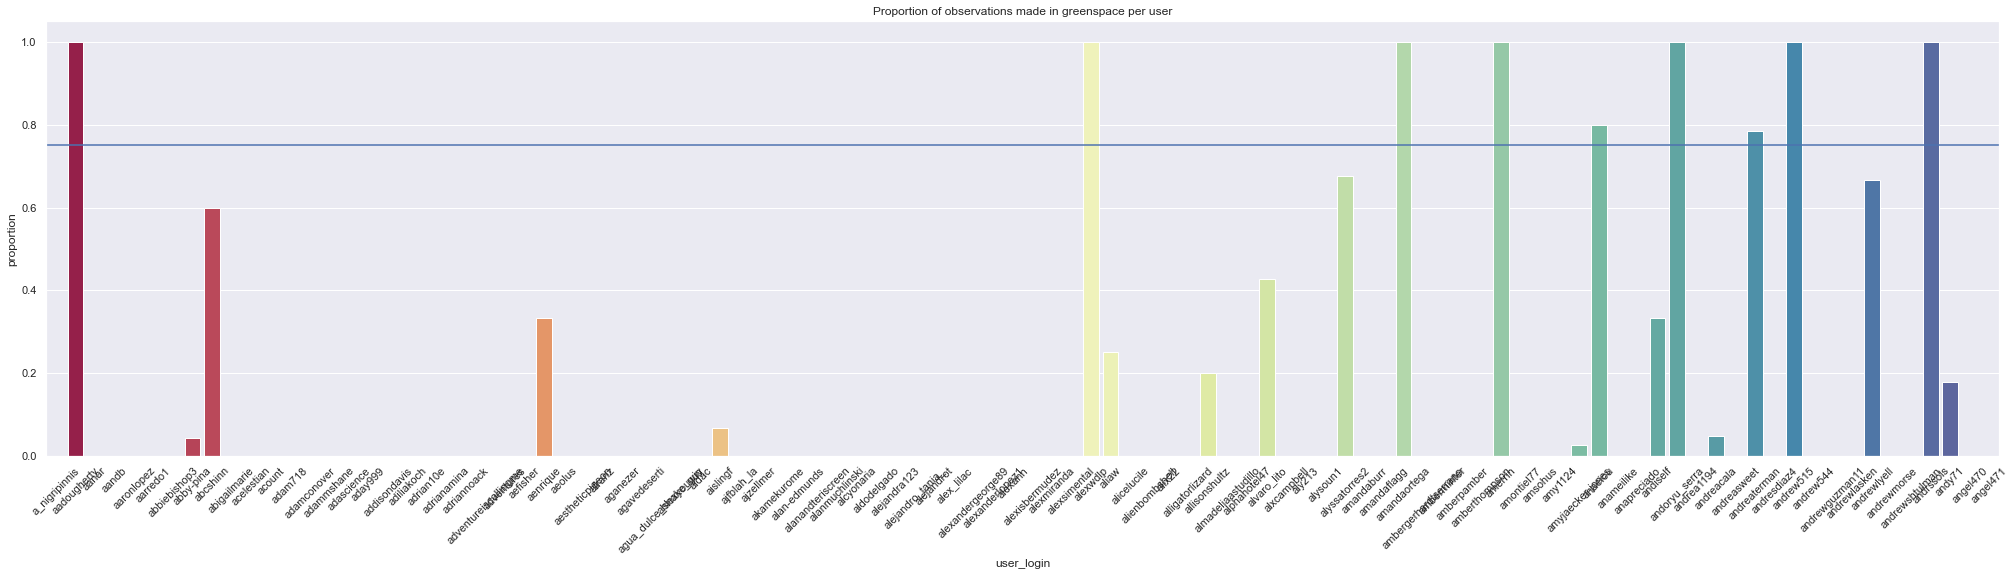

In [27]:
plt.figure(figsize=(35, 8))
plt.title('Proportion of observations made in greenspace per user')
plt.xticks(rotation=45)
ax = sns.barplot(x="user_login", y="proportion", data=new_proportions_20.head(100), palette='Spectral')
ax.axhline(0.75)

### amount over 75% proportion

In [28]:
len(new_proportions_20[new_proportions_20.proportion > 0.75]), len(new_proportions_19[new_proportions_19.proportion > 0.75]), len(new_proportions_18[new_proportions_18.proportion > 0.75]), len(new_proportions_17[new_proportions_17.proportion > 0.75])

(92, 301, 172, 95)

In [29]:
proportions = [len(new_proportions_17[new_proportions_17.proportion > 0.75]), len(new_proportions_18[new_proportions_18.proportion > 0.75]), len(new_proportions_19[new_proportions_19.proportion > 0.75]), len(new_proportions_20[new_proportions_20.proportion > 0.75])]
years = [2017, 2018, 2019, 2020]

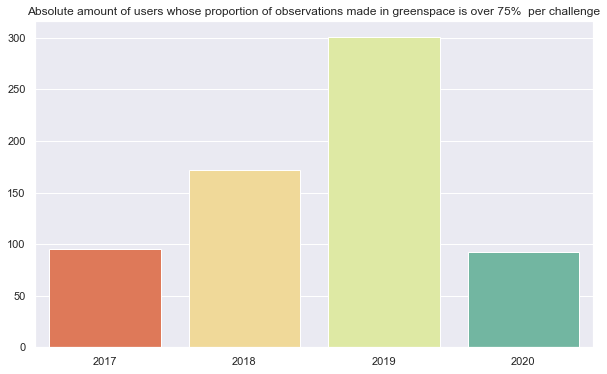

In [30]:
plt.figure(figsize=(10, 6))
plt.title('Absolute amount of users whose proportion of observations made in greenspace is over 75%  per challenge')
ax = sns.barplot(x=years, y=proportions, palette='Spectral')

In [31]:
proportions = [len(new_proportions_17[new_proportions_17.proportion > 0.75])/len(new_proportions_17),
               len(new_proportions_18[new_proportions_18.proportion > 0.75])/len(new_proportions_18), 
               len(new_proportions_19[new_proportions_19.proportion > 0.75])/len(new_proportions_19), 
               len(new_proportions_20[new_proportions_20.proportion > 0.75])/len(new_proportions_20)]

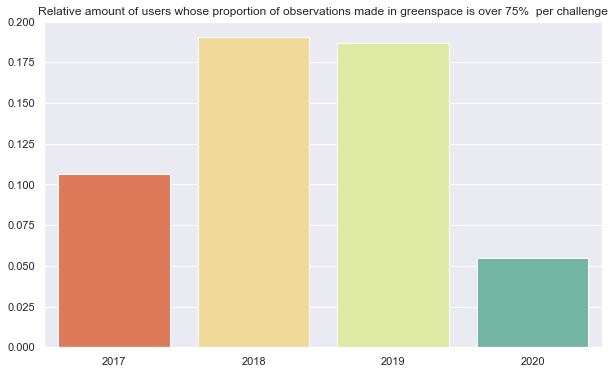

In [32]:
## also relatively compared to the total amount of users in this year 
plt.figure(figsize=(10, 6))
plt.title('Relative amount of users whose proportion of observations made in greenspace is over 75%  per challenge')
ax = sns.barplot(x=years, y=proportions, palette='Spectral')

In [33]:
fig = ax.get_figure()
fig.savefig("la_greenspace_proportion.png")

In [34]:
prop = pd.DataFrame(list(zip(years, proportions)), columns=['year', 'proportion'])
prop['city'] = 'Los Angeles'
prop

,year,proportion,city
0,2017,0.106622,Los Angeles
1,2018,0.190687,Los Angeles
2,2019,0.186840,Los Angeles
3,2020,0.054599,Los Angeles


In [35]:
prop.to_csv('la_proportions.csv')

In [36]:
ldn_prop = pd.read_csv('london_proportions.csv', index_col=0)
sf_prop = pd.read_csv('sf_proportions.csv', index_col=0)

In [37]:
ldn_prop.head()

,year,proportion,city
0,2018,0.357798,London
1,2019,0.384342,London
2,2020,0.167558,London


In [39]:
bigdata = pd.concat([prop, ldn_prop, sf_prop], ignore_index=True, sort=False)
bigdata

,year,proportion,city
0,2017,0.106622,Los Angeles
1,2018,0.190687,Los Angeles
2,2019,0.186840,Los Angeles
3,2020,0.054599,Los Angeles
4,2018,0.357798,London
5,2019,0.384342,London
6,2020,0.167558,London
7,2017,0.193838,San Francisco
8,2018,0.255271,San Francisco
9,2019,0.186165,San Francisco


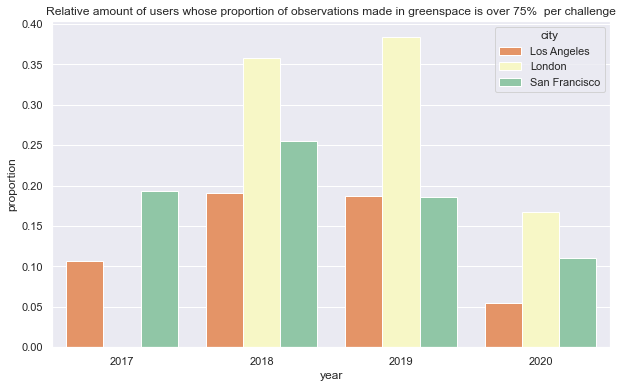

In [42]:
plt.figure(figsize=(10, 6))
plt.title('Relative amount of users whose proportion of observations made in greenspace is over 75%  per challenge')
ax = sns.barplot(x='year', y='proportion', data=bigdata, hue='city', palette='Spectral')

In [43]:
fig = ax.get_figure()
fig.savefig("all_proportions.png")

### Analyze Greenspace flags by time 

In [6]:
la_data['observed_on'] = pd.to_datetime(la_data['time_observed_at']).dt.date
la_data['observed_on'] = pd.to_datetime(la_data['observed_on'])
la_data.observed_on.unique()

array(['2017-04-14T00:00:00.000000000', '2017-04-15T00:00:00.000000000',
       '2017-04-16T00:00:00.000000000', '2017-04-17T00:00:00.000000000',
       '2017-04-18T00:00:00.000000000', '2017-04-19T00:00:00.000000000',
       '2017-05-11T00:00:00.000000000', '2017-09-27T00:00:00.000000000',
       '2016-04-16T00:00:00.000000000', '2020-04-24T00:00:00.000000000',
       '2020-04-25T00:00:00.000000000', '2020-04-26T00:00:00.000000000',
       '2020-04-27T00:00:00.000000000', '2020-04-28T00:00:00.000000000',
       '2019-04-28T00:00:00.000000000', '2019-04-26T00:00:00.000000000',
       '2019-04-27T00:00:00.000000000', '2019-04-29T00:00:00.000000000',
       '2019-04-30T00:00:00.000000000', '2018-04-29T00:00:00.000000000',
       '2018-04-28T00:00:00.000000000', '2018-04-27T00:00:00.000000000',
       '2018-04-30T00:00:00.000000000', '2018-05-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [7]:
greenspace_by_date = la_data.groupby(['observed_on'])['greenspace_flag'].value_counts().to_frame()
greenspace_by_date.rename(columns={'greenspace_flag':'counts'}, inplace=True)
greenspace_by_date.reset_index(inplace=True)
greenspace_by_date['observed_on'] = greenspace_by_date['observed_on'].dt.strftime('%Y-%m-%d')
greenspace_by_date.head()

,observed_on,greenspace_flag,counts
0,2016-04-16,0,2
1,2017-04-14,1,1534
2,2017-04-14,0,1516
3,2017-04-15,0,3131
4,2017-04-15,1,906


[Text(0, 0, '2016-04-16'),
 Text(1, 0, '2017-04-14'),
 Text(2, 0, '2017-04-15'),
 Text(3, 0, '2017-04-16'),
 Text(4, 0, '2017-04-17'),
 Text(5, 0, '2017-04-18'),
 Text(6, 0, '2017-04-19'),
 Text(7, 0, '2017-05-11'),
 Text(8, 0, '2017-09-27'),
 Text(9, 0, '2018-04-27'),
 Text(10, 0, '2018-04-28'),
 Text(11, 0, '2018-04-29'),
 Text(12, 0, '2018-04-30'),
 Text(13, 0, '2018-05-01'),
 Text(14, 0, '2019-04-26'),
 Text(15, 0, '2019-04-27'),
 Text(16, 0, '2019-04-28'),
 Text(17, 0, '2019-04-29'),
 Text(18, 0, '2019-04-30'),
 Text(19, 0, '2020-04-24'),
 Text(20, 0, '2020-04-25'),
 Text(21, 0, '2020-04-26'),
 Text(22, 0, '2020-04-27'),
 Text(23, 0, '2020-04-28')]

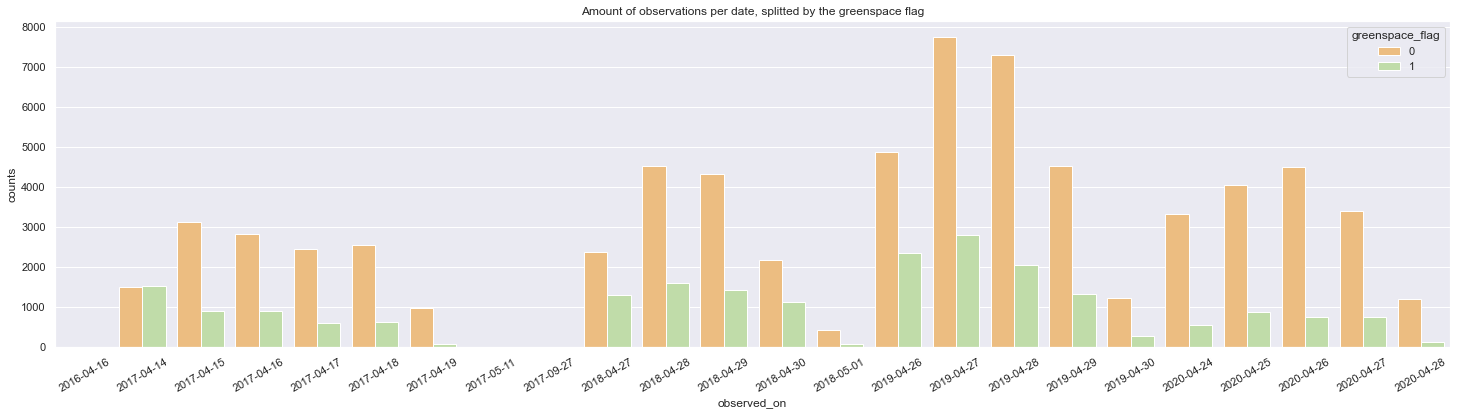

In [8]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(25, 6))
plt.title('Amount of observations per date, splitted by the greenspace flag')
ax = sns.barplot(x='observed_on', y='counts', hue='greenspace_flag', data=greenspace_by_date, palette='Spectral')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

In [9]:
greenspace_by_date.set_index(['observed_on', 'greenspace_flag'], inplace=True)
for date in greenspace_by_date.index.unique(level='observed_on'):
    if (date, 1) in greenspace_by_date.index.unique() and (date, 0) in greenspace_by_date.index.unique():
        greenspace_by_date.loc[(date, 0), 'proportion'] = greenspace_by_date.loc[(date, 0), 'counts'] / (greenspace_by_date.loc[(date, 1), 'counts'] + greenspace_by_date.loc[(date, 0), 'counts'])
        greenspace_by_date.loc[(date, 1), 'proportion'] = greenspace_by_date.loc[(date, 1), 'counts'] / (greenspace_by_date.loc[(date, 1), 'counts'] + greenspace_by_date.loc[(date, 0), 'counts'])
greenspace_by_date.reset_index(inplace=True)
greenspace_by_date.head()

,observed_on,greenspace_flag,counts,proportion
0,2016-04-16,0,2,NaN
1,2017-04-14,1,1534,0.502951
2,2017-04-14,0,1516,0.497049
3,2017-04-15,0,3131,0.775576
4,2017-04-15,1,906,0.224424


[Text(0, 0, '2016-04-16'),
 Text(1, 0, '2017-04-14'),
 Text(2, 0, '2017-04-15'),
 Text(3, 0, '2017-04-16'),
 Text(4, 0, '2017-04-17'),
 Text(5, 0, '2017-04-18'),
 Text(6, 0, '2017-04-19'),
 Text(7, 0, '2017-05-11'),
 Text(8, 0, '2017-09-27'),
 Text(9, 0, '2018-04-27'),
 Text(10, 0, '2018-04-28'),
 Text(11, 0, '2018-04-29'),
 Text(12, 0, '2018-04-30'),
 Text(13, 0, '2018-05-01'),
 Text(14, 0, '2019-04-26'),
 Text(15, 0, '2019-04-27'),
 Text(16, 0, '2019-04-28'),
 Text(17, 0, '2019-04-29'),
 Text(18, 0, '2019-04-30'),
 Text(19, 0, '2020-04-24'),
 Text(20, 0, '2020-04-25'),
 Text(21, 0, '2020-04-26'),
 Text(22, 0, '2020-04-27'),
 Text(23, 0, '2020-04-28')]

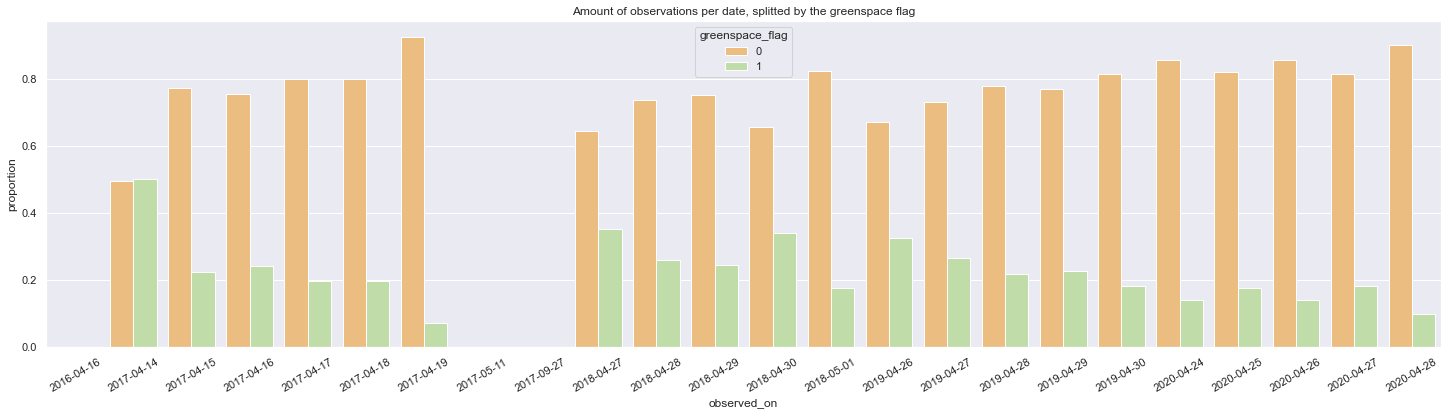

In [10]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(25, 6))
plt.title('Amount of observations per date, splitted by the greenspace flag')
ax = sns.barplot(x='observed_on', y='proportion', hue='greenspace_flag', data=greenspace_by_date, palette='Spectral')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)